# RNN 分享
> Author: zroykhi
## Why RNN?

一般神经网络的前一个输入和后一个输入是完全没有关系的（图像识别）。但是，某些任务需要能够更好的处理序列的信息，即前面的输入和后面的输入是有关系的。前面的输入可以为后面的输入提供有价值的信息。循环神经网络（Recurrent Neural Network，RNN）是一种用于处理序列数据的神经网络。相比一般的神经网络来说，他能够处理序列变化的数据。

例子：

- [ ]  时间相关
1. 音频
2. 视频
3. 传感器信号（心跳，地理位置）
4. stock market
- [ ]  有序的
1. Text/Words

## 理解经典的 Naive RNN

<div align='center'\>
　　<img src=asset/image/rnn.png width=400 />
   <br />
   Naive RNN
</div>

### 公式

$a^t = g_a(W_{ax}x^t+W_{aa}a^{t-1}+b_a)$

$y_t = g_y(W_{ya}a^t + b_y)$

---

- $a^t$: t时刻的hidden state
- $g_a,g_y$: 激活函数
- $W_{ax}$: 输入层到隐藏层的权重矩阵
- $W_{aa}$: 隐藏层上一时刻的值作为这一次的输入对应的权重矩阵
- $W_{ya}$: 隐藏层到输出层的权重矩阵
- $b_a,b_y$: bias

### 存在问题

梯度爆炸/梯度消失：无论是梯度消失还是梯度爆炸，都是源于网络结构太深，造成网络权重不稳定，从本质上来讲是因为梯度反向传播中的连乘效应。这使得循环神经网络模型很难学习到输入序列中的长距离依赖关系。

给定一个三个时间的RNN单元，如下[2]：

<div align='center'\>
　　<img src=asset/image/1.png width=400 />
</div>

我们假设最左端的输入 $S_0$ 为给定值， 且神经元中没有激活函数（便于分析）， 则前向过程如下：

<div align='center'\>
　　<img src=asset/image/2.png width=400 />
</div>

在 $t=3$ 时刻， 损失函数为 $L_3 = \frac{1}{2}(Y_3-O_3)^2$ ，那么如果我们要训练RNN时， 实际上就是是对 $W_x, W_s, W_o, b_1, b_2$ 求偏导， 并不断调整它们以使得 $L_3$ 尽可能达到最小（反向传播算法与梯度下降算法)。那么我们得到以下公式：

<div align='center'\>
　　<img src=asset/image/3.png width=400 />
</div>

我们发现， 随着神经网络层数的加深对 $W_0$ 而言并没有什么影响， 而对 $W_x, W_s$ 会随着时间序列的拉长而产生梯度消失和梯度爆炸问题。

根据上述分析整理一下公式可得， 对于任意时刻 $t$ 对 $W_x, W_s$ 求偏导的公式为：

<div align='center'\>
　　<img src=asset/image/4.png width=400 />
</div>

我们发现， 导致梯度消失和爆炸的就在于 $\prod_{j=k+1}^t{\delta S_j \over {\delta S_{j-1}}}$ ， 而加上激活函数后的S的表达式为：

<div align='center'\>
　　<img src=asset/image/5.png width=400 />
</div>

那么则有：


<div align='center'\>
　　<img src=asset/image/6.png width=250 />
</div>

<div align='center'\>
　　<img src=asset/image/7.png width=300 />
</div>

而在这个公式中， $tanh$ 的导数总是小于1 的， 如果 $W_s$ 也是一个大于0小于1的值， 那么随着 $t$ 的增大，上述公式的值越来越趋近于0， 这就导致了梯度消失问题(之前时间点远的输入对当前的梯度贡献很小，信息不能传导)。 那么如果 $W_s$ 很大， 上述公式会越来越趋向于无穷， 这就产生了梯度爆炸(训练不稳定，甚至为 NaN)。如果我们能够将这一坨东西去掉， 我们的不就解决掉梯度问题了吗？

<div align='center'\>
　　<img src=asset/image/8.png width=400 />
   <br />
   形象理解 RNN 短期记忆问题
</div>



缓解办法：

1. 梯度截断，将梯度大小限制在一定范围内，避免过大过小
2. 减短时间步长/跳过一些时间
3. 采用Relu、LeakRelu、elu等激活函数
4. 采用归一化（BN,LN,）
5. 其他的 RNN 网络结构（LSTM，GRU ）

## 常见的循环神经网络结构

### LSTM(Long Short-Term Memory)

<div align='center'\>
　　<img src=asset/image/9.png width=400 />
</div>

LSTM 选择加门的方式缓解 RNN 的长期记忆问题。“门”是一种有选择的让信息通过的方式。它们由sigmoid神经网络层和元素积操作组成。sigmoid层输出[0,1]区间的数字（要么接近于0 ， 要么接近于1），用于决定有多少信息能够通过。0代表“任何信息都拒绝通过”，1代表“任何信息都可以通过”。LSTM有三种门，用于保护和控制单元状态。

| | |
:-------------------------:|:-------------------------:
<img src=asset/image/10.png width="400" />  | ![alt text](asset/image/11.png)

遗忘门（forget gate）

> 遗忘门决定了上一时刻的单元状态 $c_{t-1}$ 有多少保留到当前时刻 $c_t$。

$$f_t = \sigma(W_f*[h_{t-1},x_t] + b_f)$$

输入门（input gate）

> 输入门决定了当前时刻网络的输入 $x_t$ 有多少保存到单元状态 $c_t$。

$$i_t = \sigma(W_i*[h_{t-1},x_t] + b_i)$$

输出门（output gate）

> 输出门就是用来控制单元状态 $c_t$ 有多少输入到 LSTM 的当前输出值 $h_t$ 。

$$o_t = \sigma(W_o*[h_{t-1},x_t] + b_o)$$

当前单元状态：

$$c_t = f_t ∘c_{t-1}+i_t∘tanh(W_c*[h_{t-1},x_t]+b_c)$$

当前时刻的隐藏层输出：

$$h_t = o_t∘tanh(c_t)$$

$∘$：Hadamard Product，也就是操作矩阵中对应的元素相乘。

当前单元对上一个单元求偏导：${\delta c_t \over {\delta c_{t-1}}} = f_t = \sigma(W_f*[h_{t-1},x_t] + b_f)$， 虽然$f_t$是一个[0,1]区间的数值，不在满足当前记忆单元对上一记忆单元的偏导为常数。但通常会给遗忘门设置一个很大的偏置项，使得遗忘门在多数情况下是关闭的，只有在少数情况下开启。回顾下遗忘门的公式，这里我们加上了偏置$b_f$。当$f_t$趋向于1时，遗忘门关闭无作用，趋向于0时，遗忘门打开。通过设置大的偏置项，使得大多数遗忘门的值趋于1。也就缓解了由于小数连乘导致的梯度消失问题。

相比RNN只有一个传递状态 $h_t$ ，LSTM有两个传输状态，一个 $c_t$ （cell state），和一个 $h_t$（hidden state）。（Tips：RNN中的 $h_t$ 对于LSTM中的 $c_t$ ）。其中对于传递下去的 $c_t$ （长期记忆）改变得很慢。而 $h_t$ （短期记忆）则在不同节点下往往会有很大的区别。

LSTM的参数量是Naive RNN的4倍（看公式计算矩阵维度），参数量过多就会存在过拟合的风险

<div align='center'\>
　　<img src=asset/image/12.png width=400 />
</div>

### GRU（Gate Recurrent Unit）

GRU 主要是在 LSTM 的模型上做了一些简化和调整，在训练数据集比较大的情况下可以节省很多时间。GRU只使用两个门控开关，达到了和LSTM接近的结果。其参数量是Naive RNN的3倍。

<div align='center'\>
　　<img src=asset/image/13.png width=400 />
</div>

它将遗忘和输入门结合成一个“更新门”，它还合并了单元状态和隐藏状态，使用了同一个门控 $z_t$ 就同时可以进行遗忘和选择记忆（LSTM则要使用多个门控）。

重置门

- $\tilde h_t = tanh(W*[r_t∘h_{t-1},x_t])$：得到门控信号之后，首先使用重置门控来得到“重置”之后的数据 $h'_{t-1} = r_t∘h_{t-1}$ ，再将 $h'_{t-1}$ 与输入 $x_t$ 进行拼接，再通过一个 tanh 激活函数来将数据放缩到-1~1的范围内。

更新门

- $(1-z_t)∘h_{t-1}$：表示对原本隐藏状态的选择性“遗忘”。这里的 $1-z_t$ 可以想象成遗忘门（forget gate），忘记 $h_{t-}$ 维度中一些不重要的信息。
- $z_t∘\tilde h_t$：表示对包含当前节点信息的 $\tilde h_t$ 进行选择性”记忆“
- $h_t=(1-z_t)∘h_{t-1}+z_t∘\tilde h_t$：结合上述，这一步的操作就是忘记传递下来的 $h_{t-1}$ 中的某些维度信息，并加入当前节点输入的某些维度信息。


## [Demo 例子](https://github.com/MorvanZhou/PyTorch-Tutorial)

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
TIME_STEP = 10       # rnn time step
INPUT_SIZE = 1       # rnn input size
HIDDEN_SIZE = 32     # hidden size
NB_HIDDEN_LAYERS = 2 # number of hidden layers
BATCH_SIZE = 1       # dummy batch size
LR = 0.02            # learning rate

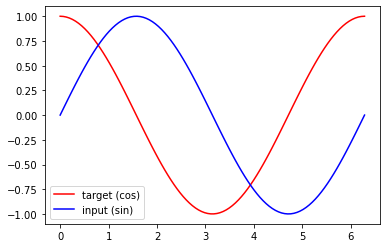

In [4]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,     # rnn hidden unit
            num_layers=NB_HIDDEN_LAYERS,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

In [6]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [8]:
h_state = None      # for initial hidden state

In [9]:
fig = plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

<Figure size 864x360 with 0 Axes>

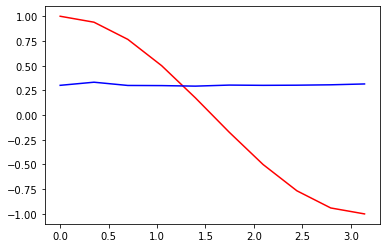

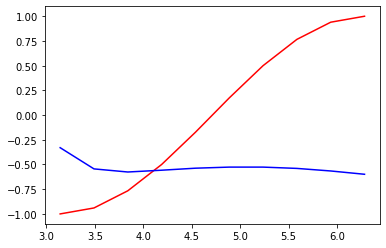

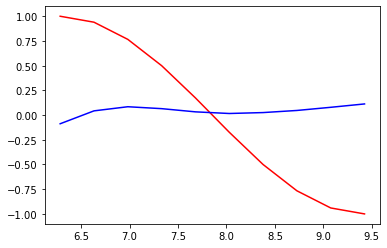

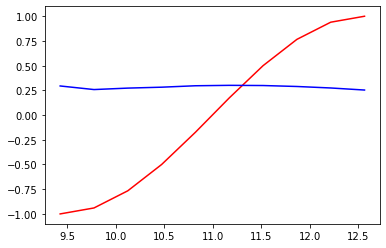

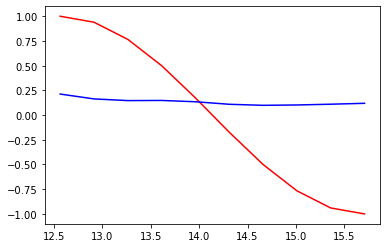

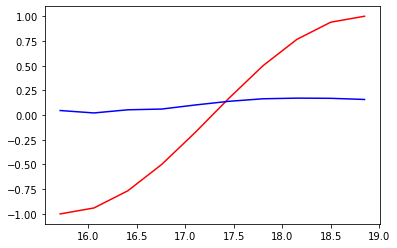

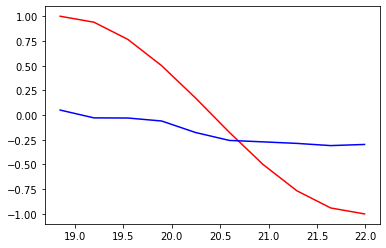

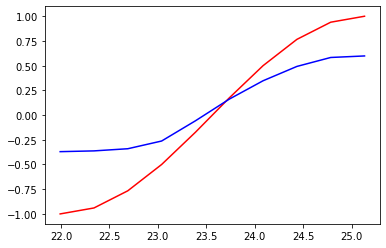

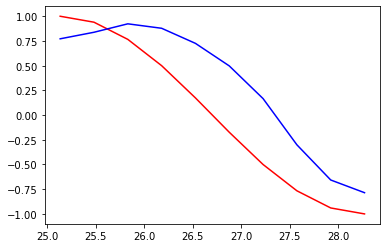

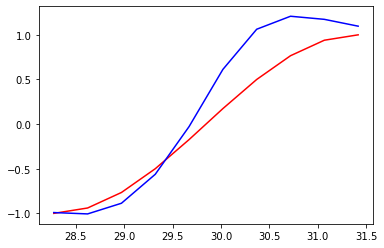

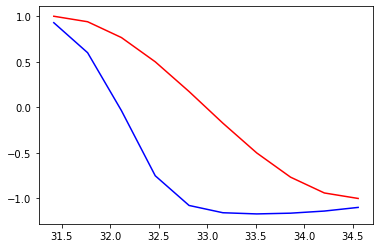

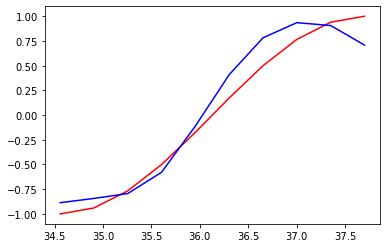

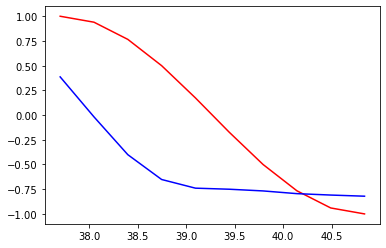

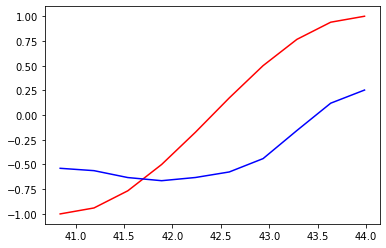

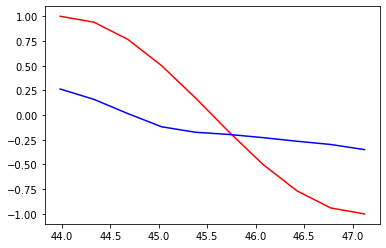

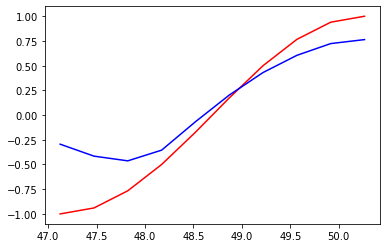

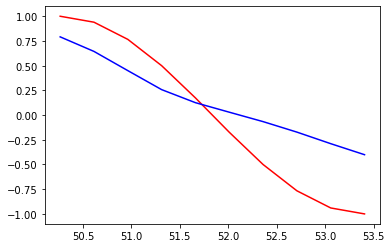

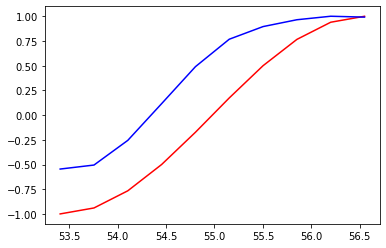

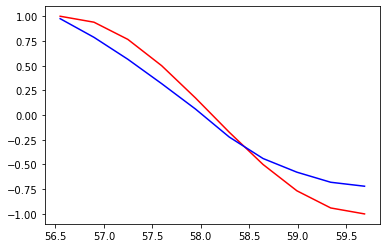

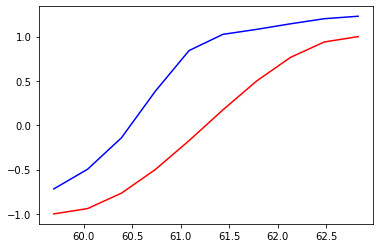

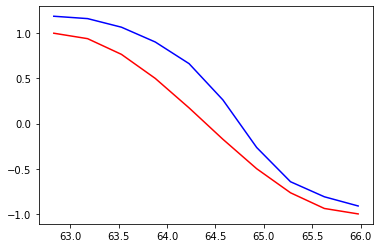

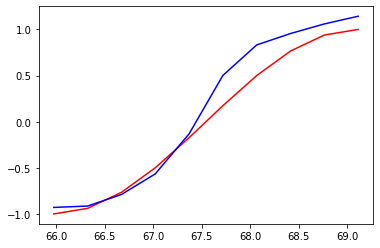

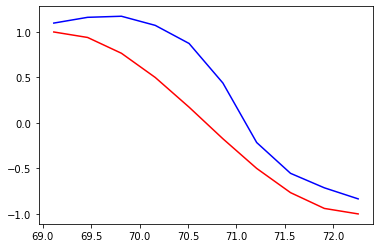

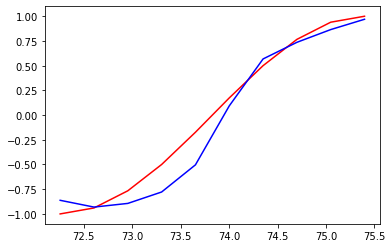

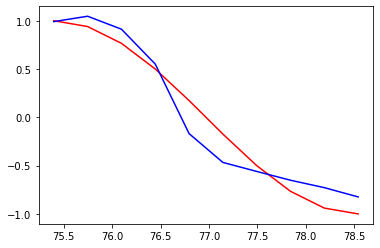

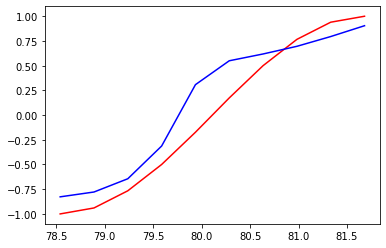

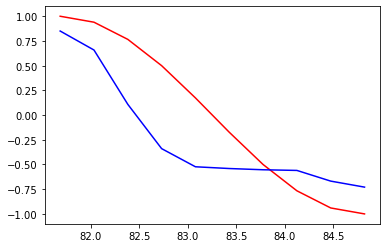

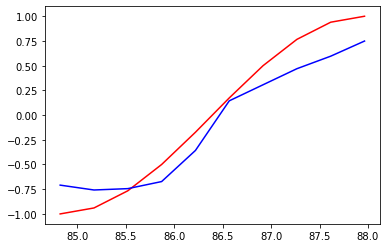

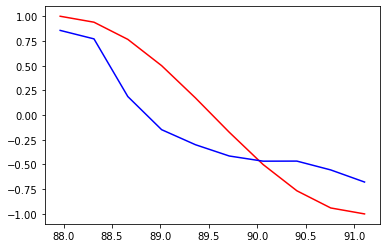

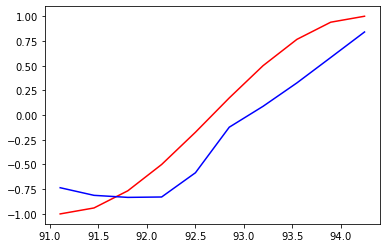

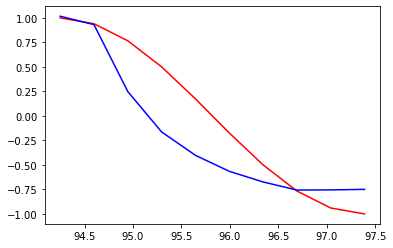

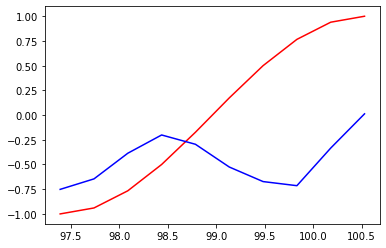

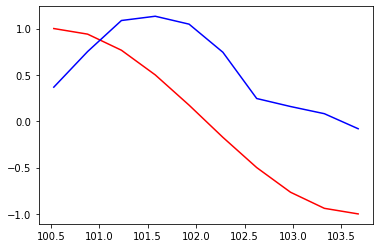

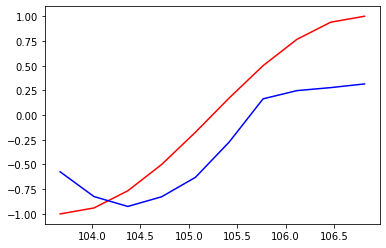

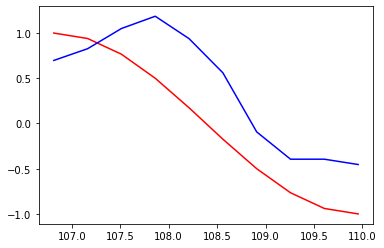

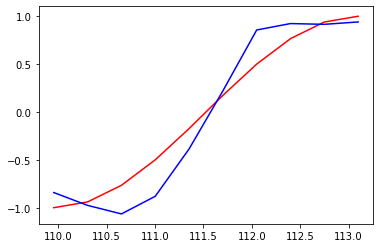

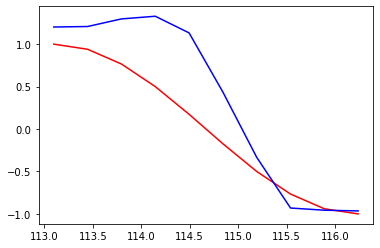

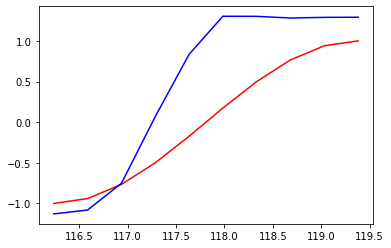

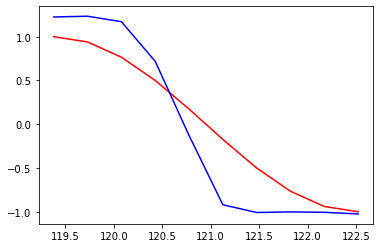

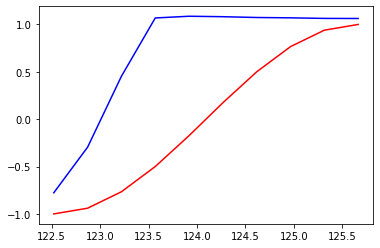

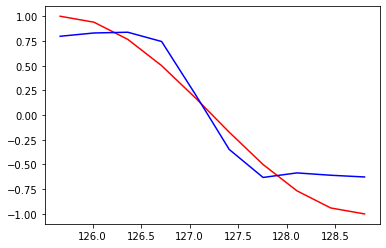

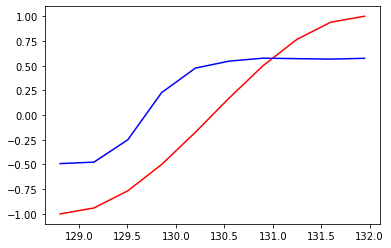

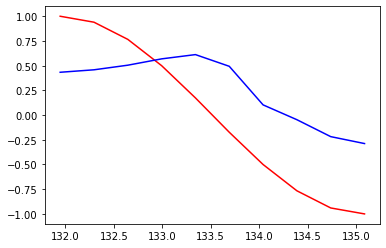

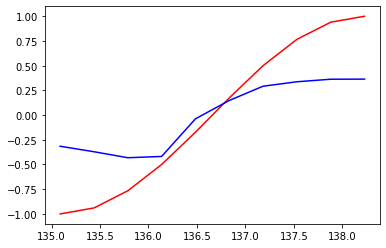

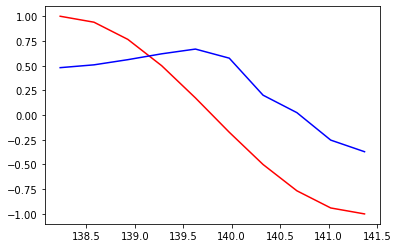

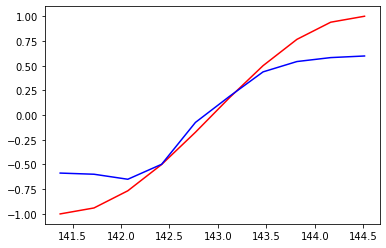

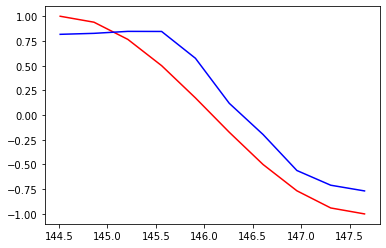

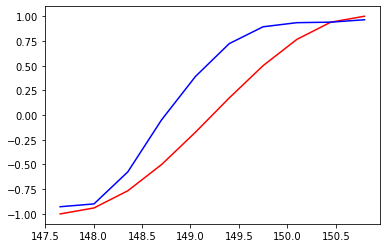

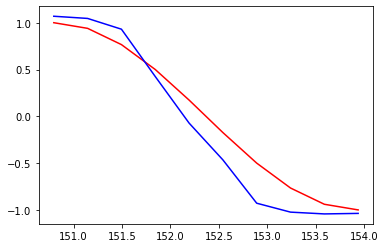

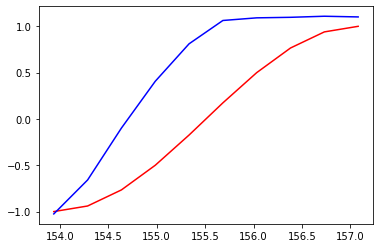

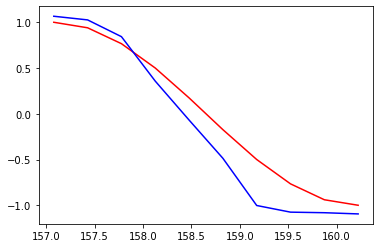

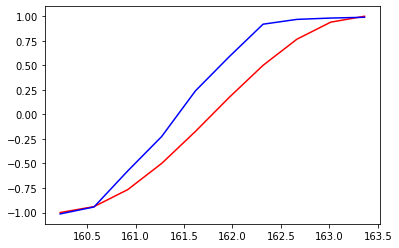

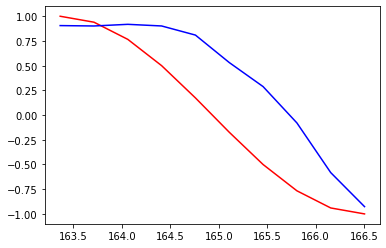

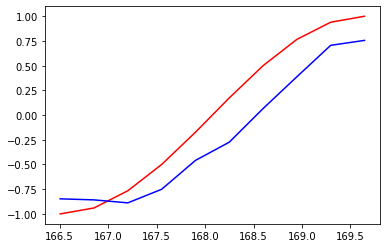

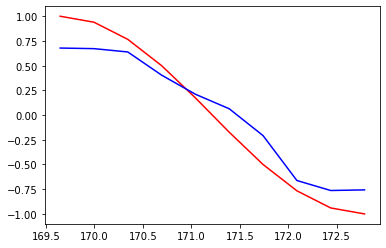

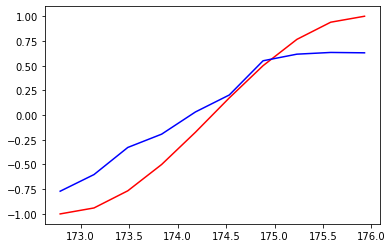

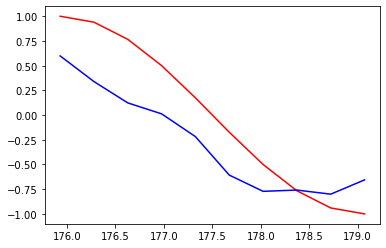

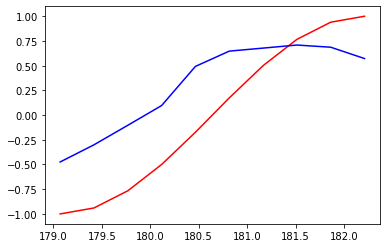

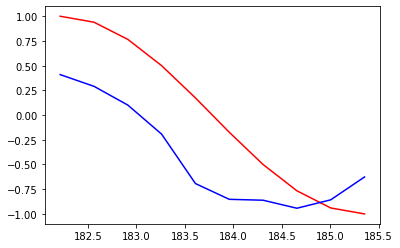

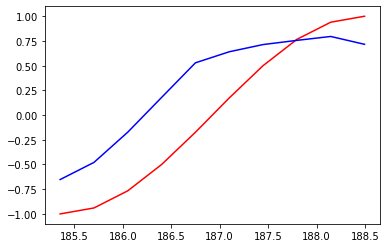

In [10]:
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)                        # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))

    prediction, h_state = rnn(x, h_state)       # rnn output
    # !! next step is important !!
    h_state = Variable(h_state.data)            # repack the hidden state, break the connection from last iteration
    loss = loss_func(prediction, y)             # cross entropy loss
    optimizer.zero_grad()                       # clear gradients for this training step
    loss.backward()                             # backpropagation, compute gradients
    optimizer.step()                            # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.1)

In [11]:
dummy_input = torch.randn(BATCH_SIZE,TIME_STEP,INPUT_SIZE,dtype=torch.float32,device='cpu')
dummy_state = torch.randn(NB_HIDDEN_LAYERS,BATCH_SIZE,HIDDEN_SIZE,dtype=torch.float32,device='cpu')
torch.onnx.export(
    rnn,
    (dummy_input,dummy_state),
    "rnn_demo.onnx",
    verbose=False,
    input_names=["sin"],
    output_names=["cos", "hidden.1"]
)

<ipython-input-5-b3d3cd8e880d>:20: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  for time_step in range(r_out.size(1)):    # calculate output for each time step
/Users/admin/opt/anaconda3/envs/ml/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:1801: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


## Reference

1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. [RNN 的梯度消失问题](https://zhuanlan.zhihu.com/p/44163528)
3. [RNN梯度消失和爆炸的原因](https://zhuanlan.zhihu.com/p/28687529)
4. [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
5. [一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)
6. [RNN,LSTM,GRU计算方式及优缺点](https://blog.csdn.net/MrR1ght/article/details/106886409)
7. [人人都能看懂的LSTM](https://zhuanlan.zhihu.com/p/32085405)
8. [人人都能看懂的GRU](https://zhuanlan.zhihu.com/p/32481747)